In [2]:
from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker

import seaborn as sns


from global_config import config
import pandas as pd
import numpy as np
import rpy2
import os

from datetime import date, timedelta


data_dir_mnps   = config.get_property('geo_dir')
data_dir        = config.get_property('data_dir')
fb_ppl_data     = config.get_property('covid_fb')
results_dir     = config.get_property('results_dir')
data_cases_path = os.path.join(fb_ppl_data, 'agglomerated', 'geometry')


In [7]:

# Defines lockdowns
no_lock_lab = "No Lockdown Imposed"
lock_lab    = "Lockdown Imposed"


lockdowns = []
lockdowns.append({"code": "A",
                  "start_date" : pd.to_datetime("2020-07-13"),
                  "end_date"   : pd.to_datetime("2020-07-23"),
                  "places":["chapinero",
                            "los_martires",
                            "san_cristobal",
                            "tunjuelito",
                            "rafel_uribe_uribe",
                            "ciudad_bolivar",
                            "santa_fe",
                            "usme"]})

lockdowns.append({"code": "B",
                  "start_date" : pd.to_datetime("2020-07-23"),
                  "end_date"   : pd.to_datetime("2020-08-06"),
                  "places":["bosa",
                            "antonio_narino",
                            "kennedy",
                            "puente_aranda",
                            "fontibon"]})

lockdowns.append({"code": "C",
                  "start_date" : pd.to_datetime("2020-07-31"),
                  "end_date"   : pd.to_datetime("2020-08-14"),
                  "places":["suba",
                            "engativa",
                            "barrios_unidos"]})

lockdowns.append({"code": "D",
                  "start_date" : pd.to_datetime("2020-08-16"),
                  "end_date"   : pd.to_datetime("2020-08-27"),
                  "places":["usaquen",
                            "chapinero",
                            "santa_fe",
                            "candelaria",
                            "teusaquillo",
                           "puente_aranda",
                           "antonio_narino"]})


In [12]:
dict_correct = {'Los Martires': 'Los Mártires', 'Fontibon': 'Fontibón', 'Engativa': 'Engativá',
                            'San Cristobal': 'San Cristóbal', 'Usaquen': 'Usaquén',
                            'Ciudad Bolivar': 'Ciudad Bolívar', 'Candelaria': 'La Candelaria'}

# load Rt locality estimates
cases_df = pd.read_csv(os.path.join(data_cases_path, 'cases.csv'), parse_dates=["date_time"])


cases_df["poly_id"]  = cases_df["poly_id"].apply(lambda s:   s.replace("colombia_bogota_localidad_",""))

cases_df["poly_name"]  = cases_df["poly_id"].apply(lambda s:   ' '.join( [word.capitalize() for word in s.replace("colombia_bogota_localidad_","").split('_') ] ) )
cases_df["poly_name"]  = cases_df["poly_name"].replace( dict_correct )

cases_bog_df = cases_df.groupby(['poly_id', 'poly_name', 'date_time']).sum()[["num_cases", "num_diseased", "num_infected_in_icu"]]
cases_bog_df = cases_bog_df.unstack([0,1]).resample('1D').sum().stack().stack().reset_index().rename(columns={'date_time':'date','num_cases': 'confirm',
                                                                                                                'num_diseased': 'deaths',
                                                                                                                'num_infected_in_icu': 'icu'})


rt_df_all = []
path_to_save = results_dir

for poly_name in cases_bog_df["poly_id"].unique():
    rt_loc = pd.read_csv(os.path.join(path_to_save, 'rt', 'rt_df_{}_confirmation.csv'.format(poly_name)))
    rt_loc["location_id"] = poly_name
    rt_loc = rt_loc[rt_loc.type=='estimate']
    rt_loc = rt_loc[rt_loc.variable=='R']
    rt_loc['date'] = rt_loc['date'].map(lambda x: pd.to_datetime(0)+timedelta(days=x))
    rt_loc = rt_loc.drop(columns=['Unnamed: 0'])
    rt_df_all.append(rt_loc)

rt_df_all = pd.concat(rt_df_all)
rt_df_all


,date,variable,strat,type,median,mean,sd,lower_90,lower_50,lower_20,upper_20,upper_50,upper_90,location_id
0,2020-03-14,R,NA_character_,estimate,1.776741,1.788429,0.164820,1.531016,1.680119,1.739704,1.820044,1.892763,2.079742,antonio_narino
1,2020-03-15,R,NA_character_,estimate,1.699241,1.707016,0.150385,1.476043,1.605850,1.663997,1.733912,1.801143,1.960841,antonio_narino
2,2020-03-16,R,NA_character_,estimate,1.616431,1.624819,0.144584,1.407748,1.525607,1.583536,1.654101,1.716474,1.870811,antonio_narino
3,2020-03-17,R,NA_character_,estimate,1.536636,1.543448,0.143658,1.322035,1.441880,1.500192,1.573392,1.633716,1.794197,antonio_narino
4,2020-03-18,R,NA_character_,estimate,1.457039,1.464396,0.144341,1.235902,1.363457,1.422957,1.494264,1.555988,1.716472,antonio_narino
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,2021-04-14,R,NA_character_,estimate,0.512427,0.513533,0.046124,0.439498,0.481247,0.501368,0.524696,0.545360,0.589619,usme
397,2021-04-15,R,NA_character_,estimate,0.469276,0.470670,0.048098,0.394049,0.437357,0.457306,0.482133,0.504178,0.550368,usme
398,2021-04-16,R,NA_character_,estimate,0.431838,0.433195,0.050039,0.353642,0.398515,0.419064,0.444571,0.468408,0.516545,usme
399,2021-04-17,R,NA_character_,estimate,0.399098,0.400776,0.051964,0.319283,0.364770,0.386441,0.412151,0.437311,0.487248,usme


In [33]:
# prelockdown period
pre_lockdown_start = pd.to_datetime("2020-06-20")
pre_lockdown_end   = pd.to_datetime("2020-07-12")

lockdown_start     = pd.to_datetime("2020-07-13")
lockdown_end       = pd.to_datetime("2020-08-27")

# poslockdown period
pos_lockdown_start = pd.to_datetime("2020-08-28")
pos_lockdown_end   = pd.to_datetime("2020-09-15")


# Assigns moments
rt_df_all.loc[(rt_df_all.date <= pre_lockdown_end)
            & (rt_df_all.date >= pre_lockdown_start),'lockdown_type'] = "pre-lockdown1"

rt_df_all.loc[(rt_df_all.date <= lockdown_end)
            & (rt_df_all.date >= lockdown_start),'lockdown_type'] = "lockdown1"

rt_df_all.loc[(rt_df_all.date <= pos_lockdown_end)
            & (rt_df_all.date >= pos_lockdown_start),'lockdown_type'] = "pos-lockdown1"


rt_df_all["lockdown_group"] = 'None'
rt_df_all["locked_down"]    = False

for lock_info in lockdowns:
    g_lockdown_start     = lock_info["start_date"]
    g_lockdown_end       = lock_info["end_date"]
    rt_df_all.loc[ (rt_df_all.date <= g_lockdown_end)
                    & (rt_df_all.date >= g_lockdown_start), 'lockdown_group'] += "-"+lock_info["code"]


    rt_df_all.loc[ (rt_df_all.date <= g_lockdown_end)
                    & (rt_df_all.date >= g_lockdown_start) & (rt_df_all.location_id.isin(lock_info["places"]) ), 'locked_down'] = True

rt_df_all["lockdown_group"] = rt_df_all["lockdown_group"].map(lambda x: x.split('-')[-1])

rt_pivoted_loc_df = pd.pivot_table(rt_df_all, values='median', index=['date', 'lockdown_type', 'lockdown_group', "locked_down"], columns=['location_id']).fillna(0).reset_index()
rt_loc_df         = pd.pivot_table(rt_df_all, values='median', index=['date', 'location_id', 'lockdown_type', 'lockdown_group', "locked_down"], columns=['variable']).fillna(0).reset_index()


In [54]:
rt_loc_df["location_id"] = rt_loc_df["location_id"].apply(lambda s: ' '.join( [word.capitalize() for word in s.split('_') ] ) )

pre_lockdown_df = rt_loc_df[ rt_loc_df["lockdown_type"] == 'pre-lockdown1' ]
A_lockdown_df   = rt_loc_df[ rt_loc_df["lockdown_group"].isin( ['A'] ) ]
B_lockdown_df   = rt_loc_df[ rt_loc_df["lockdown_group"].isin( ['B'] ) ]
C_lockdown_df   = rt_loc_df[ rt_loc_df["lockdown_group"].isin( ['C'] ) ]
D_lockdown_df   = rt_loc_df[ rt_loc_df["lockdown_group"].isin( ['D'] ) ]
pos_lockdown_df = rt_loc_df[ rt_loc_df["lockdown_type"] == 'pos-lockdown1' ]


/Users/chaosdonkey06/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/chaosdonkey06/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


variable,date,location_id,lockdown_type,lockdown_group,locked_down,R,group
0,2020-06-20,Antonio narino,pre-lockdown1,None,False,1.137485,Pre-lockdown
1,2020-06-20,Barrios unidos,pre-lockdown1,None,False,1.267941,Pre-lockdown
2,2020-06-20,Bosa,pre-lockdown1,None,False,1.135954,Pre-lockdown
3,2020-06-20,Candelaria,pre-lockdown1,None,False,0.987836,Pre-lockdown
4,2020-06-20,Chapinero,pre-lockdown1,None,False,1.278688,Pre-lockdown
...,...,...,...,...,...,...,...
1667,2020-09-15,Suba,pos-lockdown1,None,False,1.146986,Pos-lockdown
1668,2020-09-15,Teusaquillo,pos-lockdown1,None,False,1.186848,Pos-lockdown
1669,2020-09-15,Tunjuelito,pos-lockdown1,None,False,1.001981,Pos-lockdown
1670,2020-09-15,Usaquen,pos-lockdown1,None,False,1.184380,Pos-lockdown


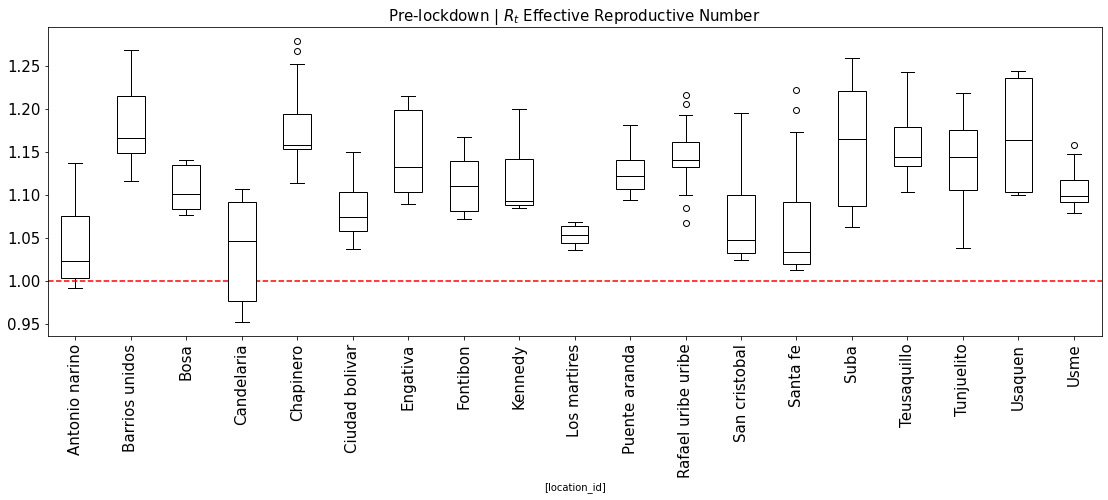

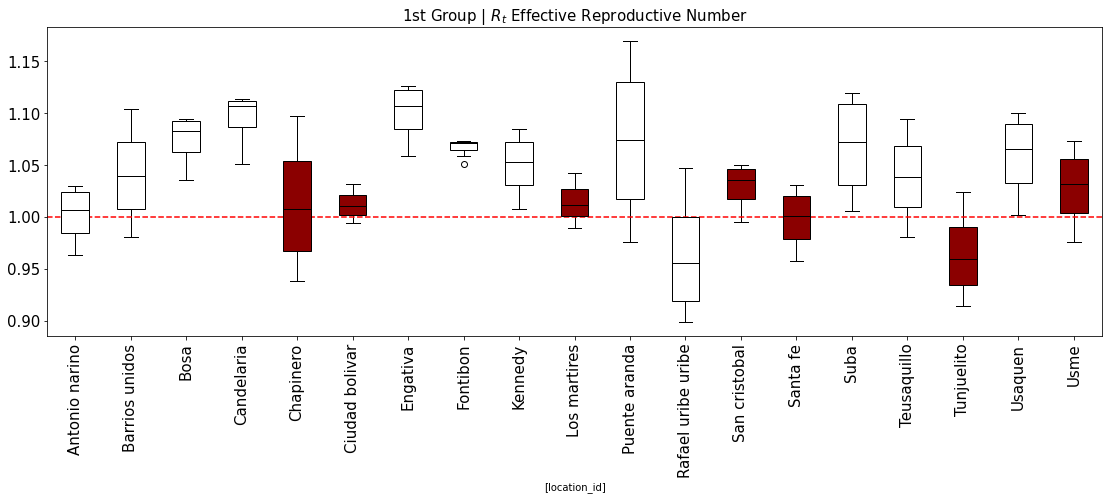

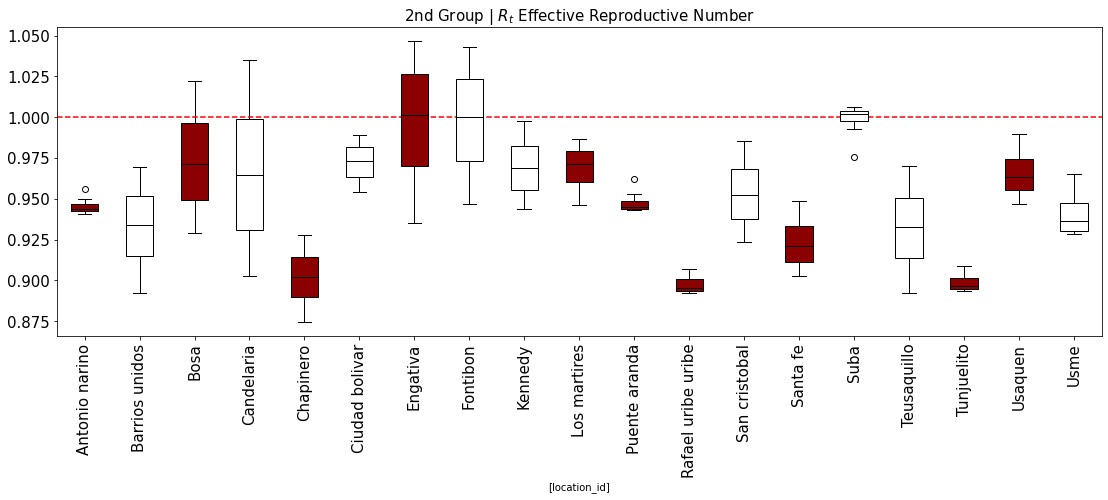

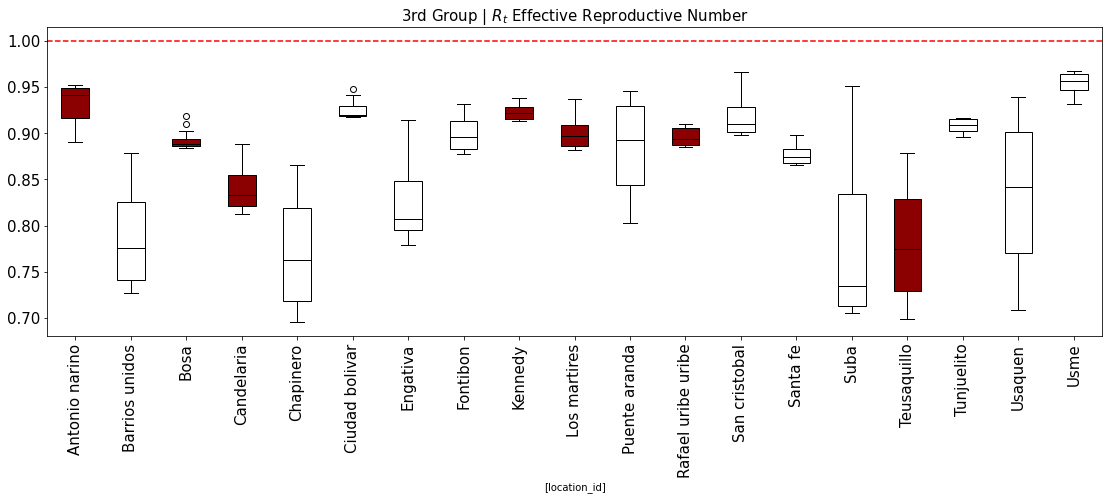

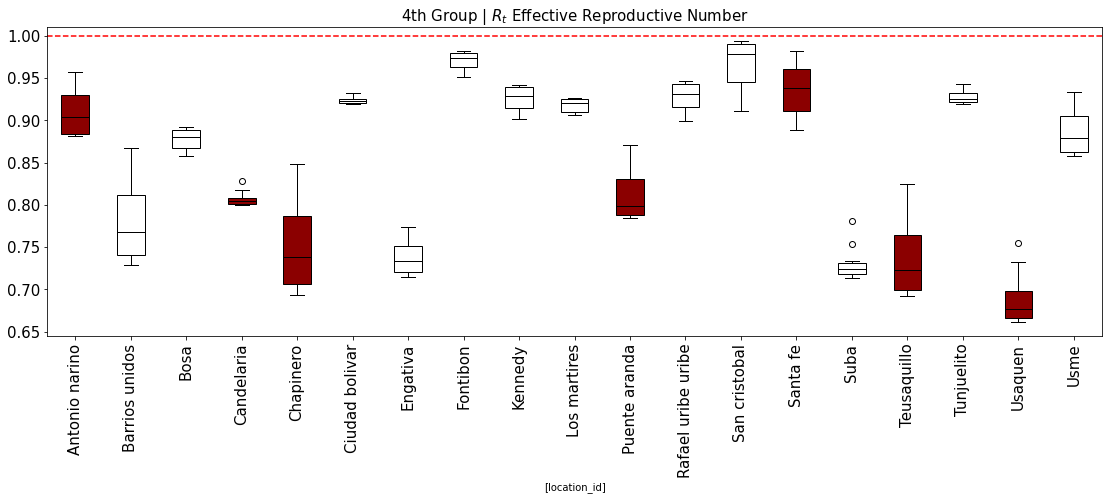

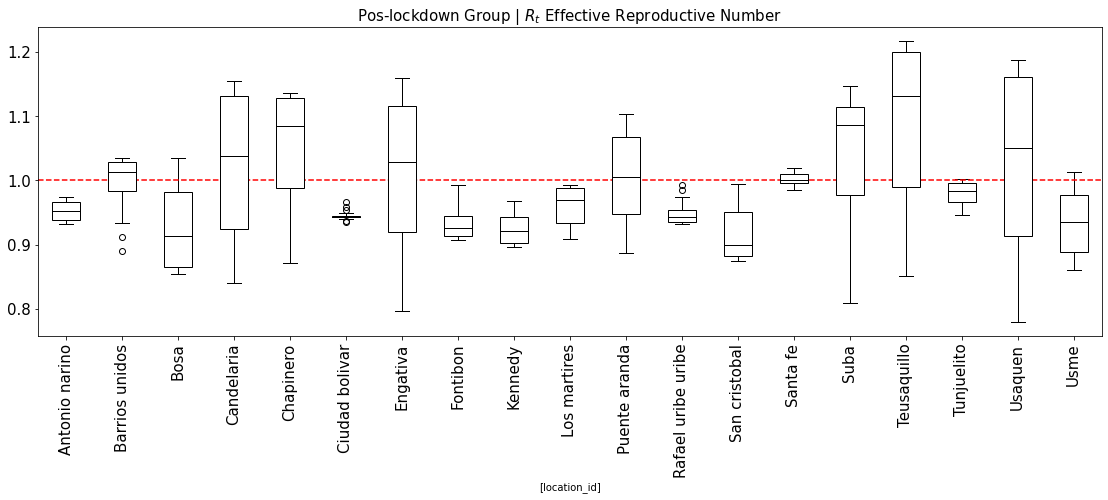

In [50]:
import matplotlib
def plot_rt_movement(df_rt, title='', path_to_save=None):
    colors = df_rt[["location_id", "lockdown_group", "locked_down"]].drop_duplicates().sort_values(by='location_id')

    fig, ax = plt.subplots(1, 1, figsize=(15.5, 7.2), sharey=False)
    boxplot = df_rt[['location_id', 'R']].boxplot(ax=ax, by='location_id', grid=False, rot=90, fontsize=15, color='k', layout=(2, 1), patch_artist=True)
    boxplot.set_title(rf'{title} | $R_t$ Effective Reproductive Number', fontsize=15)
    boxplot.get_figure().suptitle(None)
    ax.axhline(y=1, color='red', linestyle='--')

    for b in [boxplot]:
        for idx, p in enumerate( b.findobj(matplotlib.patches.Patch) ): # [3:5].set_facecolor("blue")
            if idx>len(colors)-1:
                break
            if colors.iloc[idx]["locked_down"]:
                p.set_facecolor("darkred")

            else:
                p.set_facecolor("white")

    plt.tight_layout()
    if path_to_save:
        fig.savefig(path_to_save, dpi=300,  bbox_inches='tight', transparent=False)


plot_rt_movement(pre_lockdown_df, title='Pre-lockdown',   path_to_save=None )
plot_rt_movement(A_lockdown_df,   title='1st Group',      path_to_save=None )
plot_rt_movement(B_lockdown_df,   title='2nd Group',      path_to_save=None )
plot_rt_movement(C_lockdown_df,   title='3rd Group',      path_to_save=None )
plot_rt_movement(D_lockdown_df,   title='4th Group',      path_to_save=None )
plot_rt_movement(pos_lockdown_df, title='Pos-lockdown Group',    path_to_save=None )



In [55]:
box_plot_rt_df

variable,date,location_id,lockdown_type,lockdown_group,locked_down,R,group
0,2020-06-20,Antonio narino,pre-lockdown1,None,False,1.137485,Pre-lockdown
1,2020-06-20,Barrios unidos,pre-lockdown1,None,False,1.267941,Pre-lockdown
2,2020-06-20,Bosa,pre-lockdown1,None,False,1.135954,Pre-lockdown
3,2020-06-20,Candelaria,pre-lockdown1,None,False,0.987836,Pre-lockdown
4,2020-06-20,Chapinero,pre-lockdown1,None,False,1.278688,Pre-lockdown
...,...,...,...,...,...,...,...
1667,2020-09-15,Suba,pos-lockdown1,None,False,1.146986,Pos-lockdown
1668,2020-09-15,Teusaquillo,pos-lockdown1,None,False,1.186848,Pos-lockdown
1669,2020-09-15,Tunjuelito,pos-lockdown1,None,False,1.001981,Pos-lockdown
1670,2020-09-15,Usaquen,pos-lockdown1,None,False,1.184380,Pos-lockdown


/Users/chaosdonkey06/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


NameError: name 'ç' is not defined

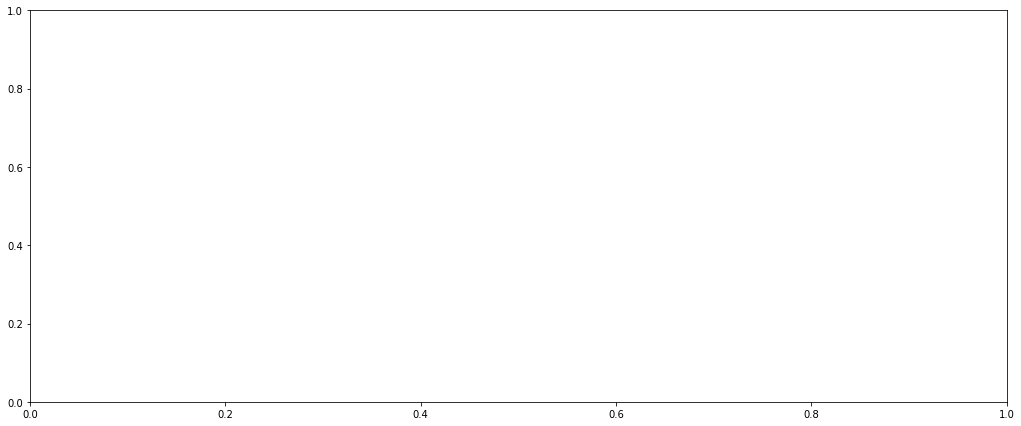

In [69]:
import seaborn as sns

pre_lockdown_df.loc[:, "group"]  = 'Pre-lockdown'
A_lockdown_df.loc[:, "group"]    = '1st Group'
B_lockdown_df.loc[:, "group"]    = '2nd Group'
C_lockdown_df.loc[:, "group"]    = '3rd Group'
D_lockdown_df.loc[:, "group"]    = '4th Group'
pos_lockdown_df.loc[:, "group"]  = 'Pos-lockdown'

box_plot_rt_df = pd.concat([pre_lockdown_df, A_lockdown_df, B_lockdown_df, C_lockdown_df, D_lockdown_df, pos_lockdown_df])

fig, ax = plt.subplots(1,1,figsize=(17.5, 7.2))
# Draw a nested boxplot to show bills by day and time

sns.boxplot(ax=ax, data=box_plot_rt_df, x="location_id", y="R", hue="group", palette='flare')

ax.set_title(r'$R_t$ Effective Reproductive Number', fontsize=15)
ax.axhline(y=1, color='red', linestyle='--')
ax.tick_params(axis='both', labelsize=15)
ax.set_ylabel(r'$R_t$', fontsize=15)
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylim([0.6, 1.5])
ax.legend(fontsize=15, loc='upper left')
plt.tight_layout()